In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm,lognorm
from scipy.stats.distributions import gamma
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import  LassoLarsIC
from sklearn import linear_model

os.chdir('C:\\Users\\atmae\\Desktop\\итмо\\Многомерный анализ\\Лаба')

In [2]:
data=pd.read_csv('weatherHistory.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
data['Date'] = pd.to_datetime(data['Formatted Date']. apply(lambda x: x[:19]))
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week'] = data['Date'].dt.week
data['Hour'] = data['Date'].dt.hour


data['Precip Type'].fillna(method = "pad", inplace = True)
data['Precip Type']=data['Precip Type'].astype('category')
data['Precip Type_int']=data['Precip Type'].cat.codes


data[['Summary']].value_counts()
popular_values = data['Summary'].value_counts().nlargest(8).index
data['Summary']=data['Summary'].apply(lambda x: x if x in popular_values else 'other')
data['Summary']=data['Summary'].astype('category')
data['Summary_int']=data['Summary'].cat.codes


# 1288 rows where Pressure equals 0 
m = data ['Pressure (millibars)'].median()
data.loc[data ['Pressure (millibars)'] ==0,  'Pressure (millibars)'] = m

<ipython-input-4-46ad0acde861>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['Week'] = data['Date'].dt.week


In [5]:
data

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Date,Year,Month,Day,Week,Hour,Precip Type_int,Summary_int
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-04-01 00:00:00,2006,4,1,13,0,0,7
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-04-01 01:00:00,2006,4,1,13,1,0,7
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 02:00:00,2006,4,1,13,2,0,5
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 03:00:00,2006,4,1,13,3,0,7
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 04:00:00,2006,4,1,13,4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.,2016-09-09 19:00:00,2016,9,9,36,19,0,7
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.,2016-09-09 20:00:00,2016,9,9,36,20,0,7
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.,2016-09-09 21:00:00,2016,9,9,36,21,0,7
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.,2016-09-09 22:00:00,2016,9,9,36,22,0,7


### Step 1. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV) .

In [8]:
df=data[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)','Precip Type_int','Precip Type', 'Summary','Summary_int','Year','Month','Week']]

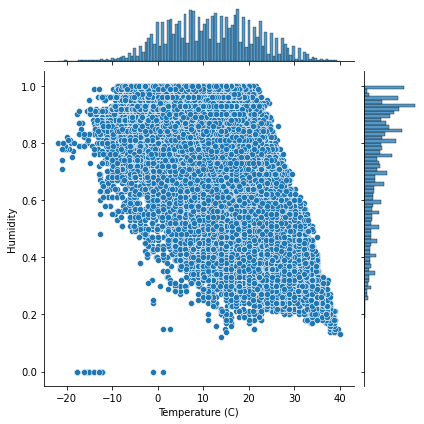

In [160]:
sns.jointplot(data=df, x='Temperature (C)', y='Humidity')

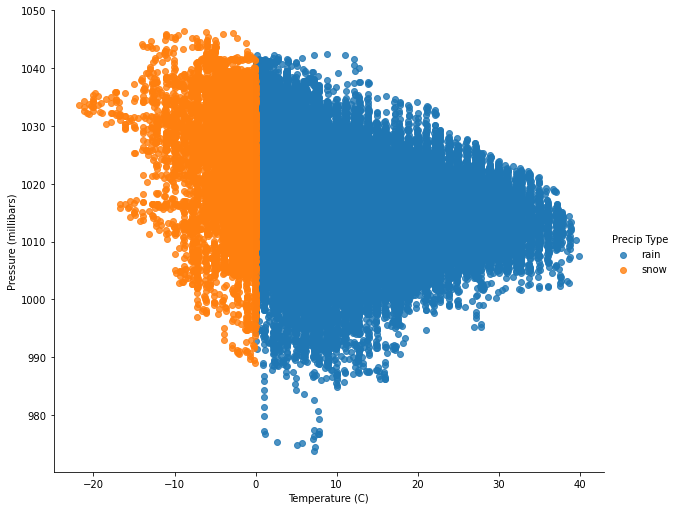

In [37]:
sns.lmplot("Temperature (C)", "Pressure (millibars)", df, hue="Precip Type", fit_reg=False, height=7, aspect=1.2)

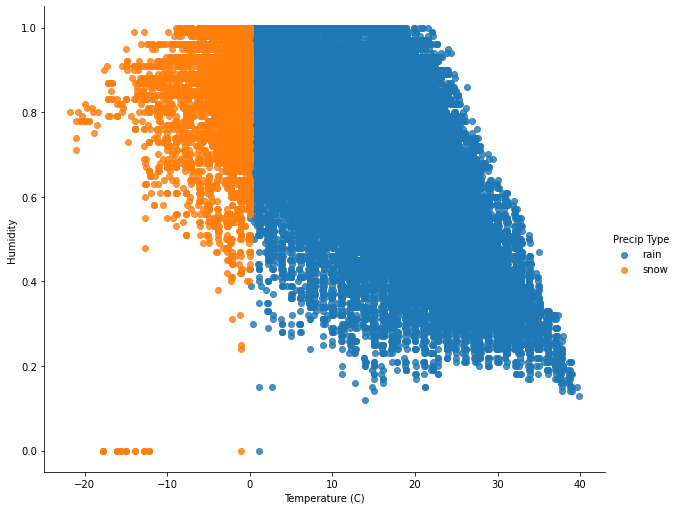

In [38]:
sns.lmplot("Temperature (C)", "Humidity", df, hue="Precip Type", fit_reg=False, height=7, aspect=1.2)

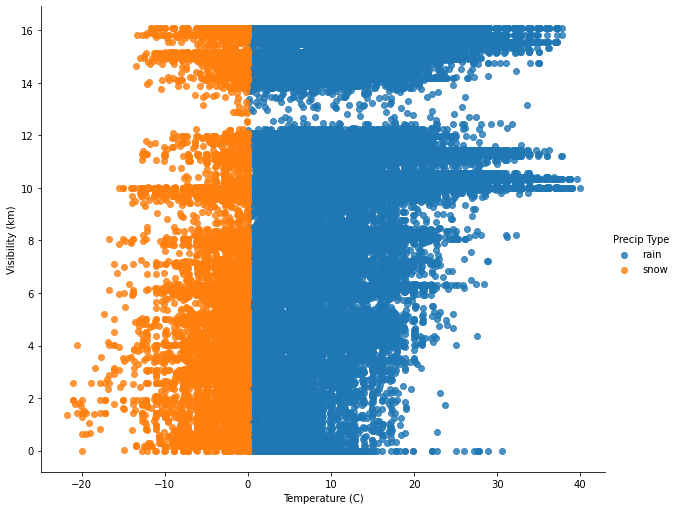

In [43]:
sns.lmplot("Temperature (C)", "Visibility (km)", df, hue="Precip Type", fit_reg=False, height=7, aspect=1.2)

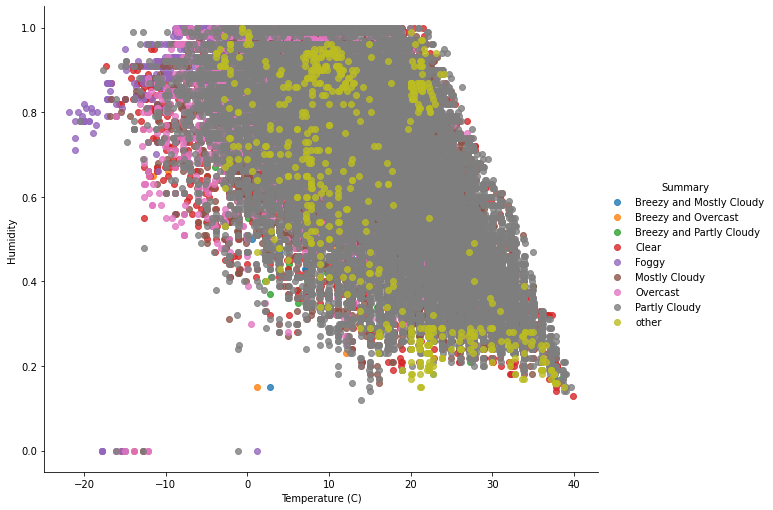

In [45]:
sns.lmplot("Temperature (C)", "Humidity", df, hue="Summary", fit_reg=False, height=7, aspect=1.2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


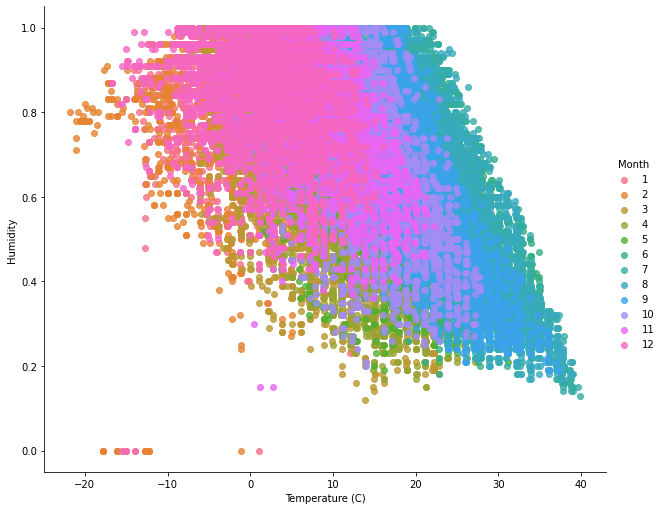

In [47]:
sns.lmplot("Temperature (C)", "Humidity", df, hue="Month", fit_reg=False, height=7, aspect=1.2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


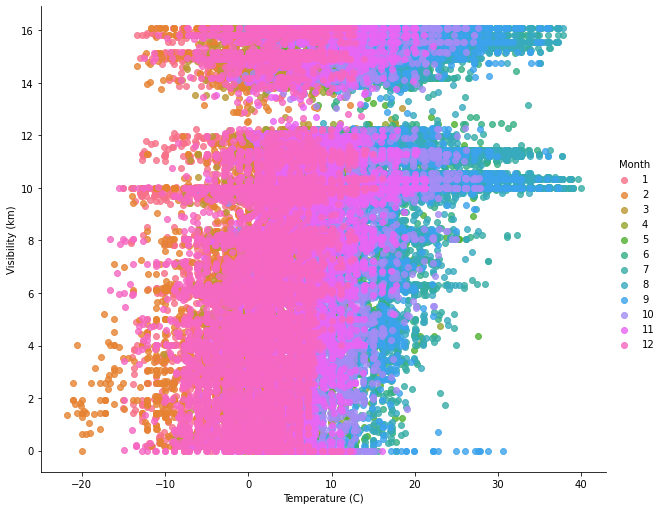

In [48]:
sns.lmplot("Temperature (C)", "Visibility (km)", df, hue="Month", fit_reg=False, height=7, aspect=1.2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


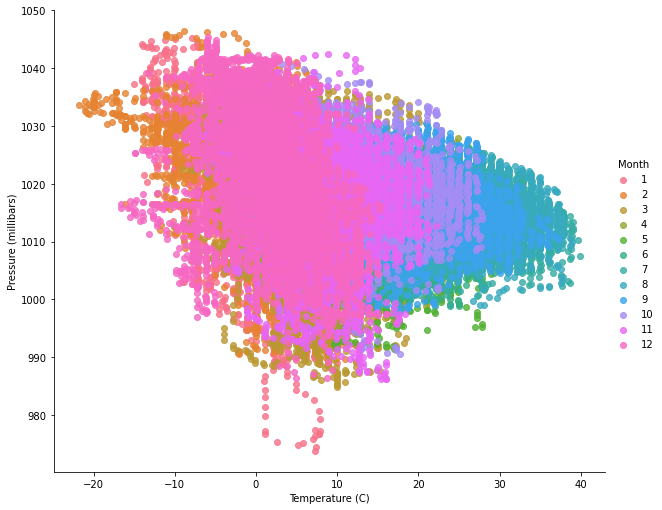

In [49]:
sns.lmplot("Temperature (C)", "Pressure (millibars)", df, hue="Month", fit_reg=False, height=7, aspect=1.2)

<Figure size 1440x1440 with 0 Axes>

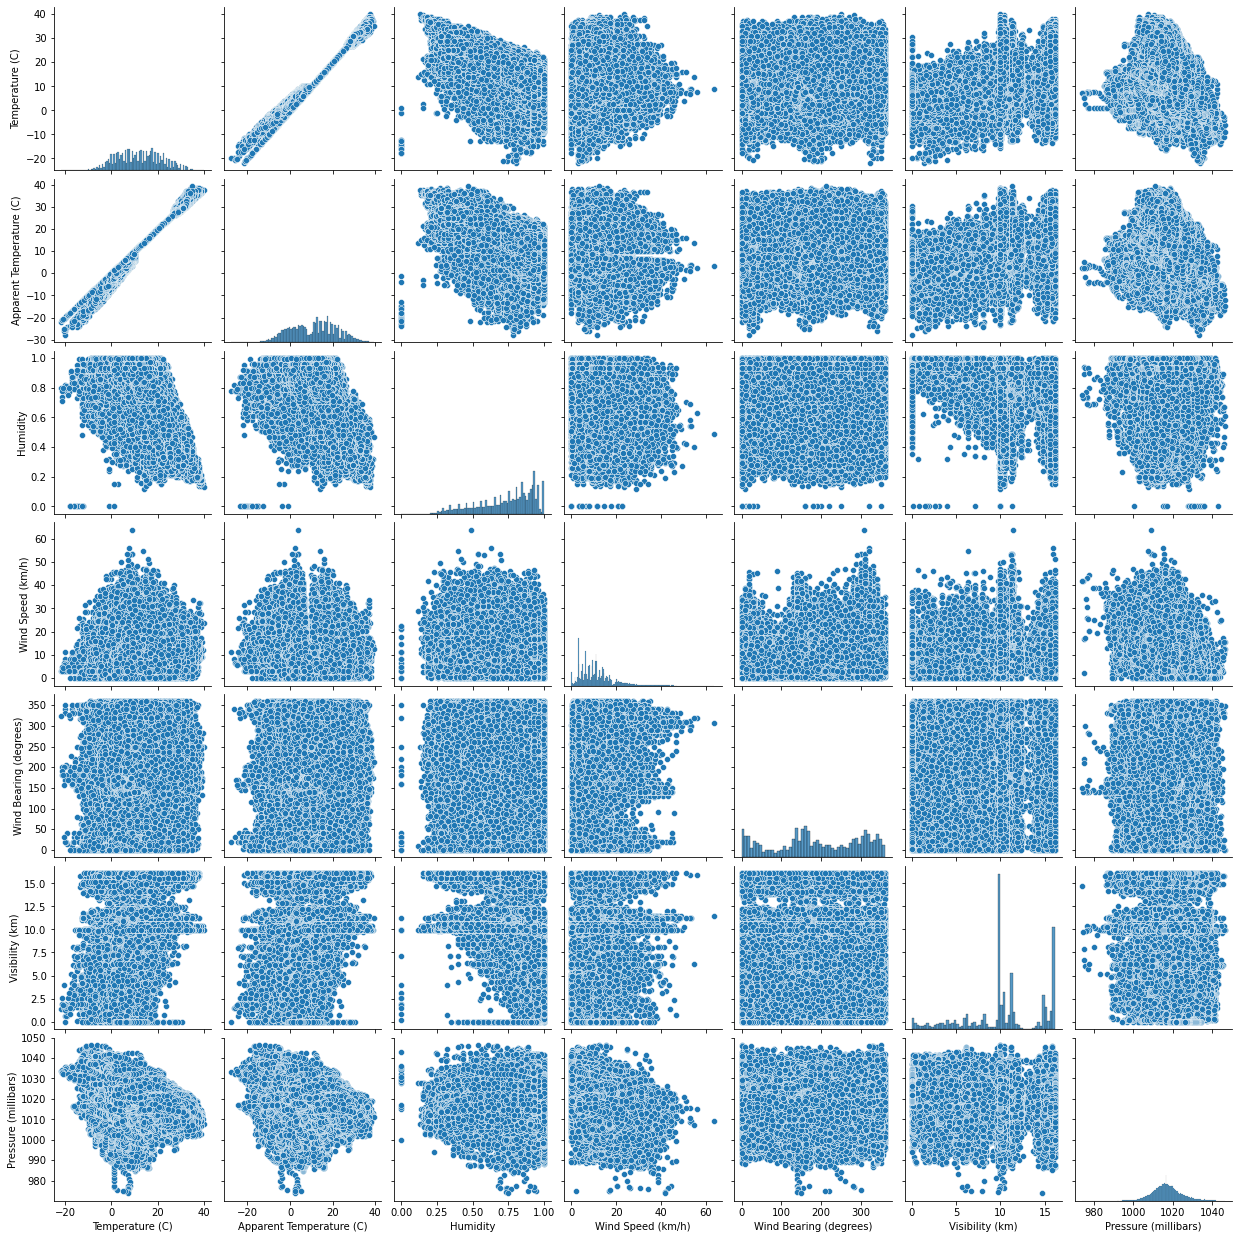

In [218]:
plt.figure(figsize=(20,20)) # this creates a figure 8 inch wide, 4 inch high
sns.pairplot(data[['Temperature (C)','Apparent Temperature (C)','Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']])
plt.show()

### Step 2 You need to make an estimation of multivariate mathematical expectation and variance.

In [70]:
print(df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].mean())
print(df.var(ddof=1))

Temperature (C)               11.932678
Humidity                       0.734899
Wind Speed (km/h)             10.810640
Visibility (km)               10.347325
Pressure (millibars)        1016.809278
Wind Bearing (degrees)       187.509232
Apparent Temperature (C)      10.855029
dtype: float64
Temperature (C)                91.232037
Humidity                        0.038210
Wind Speed (km/h)              47.797464
Visibility (km)                17.573897
Pressure (millibars)           59.696622
Wind Bearing (degrees)      11531.200691
Apparent Temperature (C)      114.422544
Precip Type_int                 0.098726
Summary_int                     2.086394
Year                            9.999139
Month                          11.892119
Week                          226.868958
dtype: float64


### Step 3. You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.

In [144]:
 dexp = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Summary']):
    dexp.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Summary']==i].apply(np.mean)
dexp

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
Overcast,7.516502,0.837232,12.027738,9.275112,1015.112576,183.532747,5.789636
Partly Cloudy,16.024782,0.648571,10.115130,11.811517,1016.988956,190.161094,15.394033
Breezy and Overcast,7.241614,0.763144,33.037566,11.067012,1007.841295,213.526515,3.492235
other,13.718251,0.593696,28.224711,10.023568,1013.791394,235.270327,11.372545
Breezy and Mostly Cloudy,11.093411,0.637054,33.386345,11.478302,1010.413816,227.639535,8.680588
Clear,11.925109,0.729708,8.141352,11.441788,1019.947339,179.180257,11.040338
Mostly Cloudy,12.629334,0.725069,11.418404,11.117234,1015.685106,192.049299,11.624994
Foggy,1.464035,0.950765,7.171649,1.551411,1021.479827,168.668439,-0.210419


In [145]:
df['Summary'].value_counts()

Partly Cloudy               31733
Mostly Cloudy               28094
Overcast                    16597
Clear                       10890
Foggy                        7148
other                         947
Breezy and Overcast           528
Breezy and Mostly Cloudy      516
Name: Summary, dtype: int64

In [146]:
 dexp = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Precip Type']):
    dexp.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Precip Type']==i].mean()
dexp

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
snow,-3.270885,0.863263,9.481998,6.636570,1023.413994,174.754294,-6.249847
rain,13.832126,0.718862,10.976633,10.810926,1015.992833,189.102763,12.992016


In [147]:
 dexp = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Year']):
    dexp.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Year']==i].mean()
dexp

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
2016,11.985292,0.760874,10.703441,11.249668,1016.319173,185.438069,10.832629
2006,11.215365,0.767341,10.189852,9.758083,1018.589657,189.342808,10.158215
2007,12.135239,0.689652,10.825392,10.408191,1017.200137,194.119292,11.063135
2008,12.161876,0.701237,11.303897,10.267119,1017.230508,193.825250,11.053184
2009,12.267910,0.707247,11.505948,10.001370,1015.593492,180.496461,11.069337
2010,11.202061,0.796858,11.015628,9.140810,1014.163811,192.067509,10.098643
2011,11.524453,0.736017,9.898262,9.507929,1018.953148,189.342352,10.584294
2012,11.986726,0.689500,11.264545,10.363108,1016.703216,187.755692,10.753081
2013,11.940719,0.754209,10.969389,10.892049,1015.851453,187.861758,10.825320
2014,12.529737,0.748578,10.502473,11.320806,1015.695428,178.226219,11.628703


In [148]:
 dexp = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Month']):
    dexp.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Month']==i].mean()
dexp

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
1,0.813890,0.850723,11.512816,7.830584,1019.580669,180.405425,-1.939615
2,2.159699,0.813400,12.185543,8.731368,1017.285961,188.717176,-0.565343
3,6.906599,0.702966,13.405461,10.910450,1015.971292,186.538480,5.074268
4,12.756417,0.641133,11.893094,11.784224,1014.608187,186.653157,12.141164
5,16.873692,0.691325,10.959337,11.892754,1014.031380,188.071237,16.732751
6,20.715617,0.686470,9.626471,11.990266,1014.306435,202.780808,20.742264
7,22.963943,0.639657,9.639907,12.187820,1014.394144,202.812248,22.976086
8,22.345031,0.635542,8.933431,12.455549,1014.947868,195.329800,22.270497
9,17.516790,0.688790,9.621813,11.602874,1017.001739,187.667424,17.404283
10,11.342247,0.774554,10.000153,9.741691,1019.541188,176.912630,10.694346


In [149]:
 dvar = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Summary']):
    dvar.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Summary']==i].var(ddof=1)
dvar

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
Overcast,50.584138,0.015231,42.843391,13.811699,82.851814,12841.336554,71.888686
Partly Cloudy,89.249982,0.041316,35.753699,9.474884,40.444207,11756.947009,107.236896
Breezy and Overcast,31.276682,0.019424,8.345418,11.002417,85.791324,11955.775387,65.266300
other,88.168737,0.055569,160.256152,12.497478,58.555060,10765.582237,132.301496
Breezy and Mostly Cloudy,44.671034,0.023751,8.518435,5.383014,81.202396,8831.186317,82.557405
Clear,100.379545,0.035913,28.564734,16.796249,45.890422,11438.578121,121.355502
Mostly Cloudy,71.479672,0.030723,38.731771,10.082809,50.775272,10491.841766,92.809804
Foggy,33.141441,0.003046,23.996018,1.084168,96.895823,10910.872842,42.864839


In [150]:
 dvar = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Precip Type']):
    dvar.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Precip Type']==i].var(ddof=1)
dvar

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
snow,9.457543,0.012323,42.667604,21.480876,88.162607,11916.154916,14.570974
rain,68.962055,0.039128,48.190763,15.150768,50.966624,11460.380097,85.777658


In [151]:
 dvar = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Year']):
    dvar.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Year']==i].var(ddof=1)
dvar

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
2016,81.559464,0.033218,37.809540,20.708225,44.527321,10210.139395,104.702621
2006,92.115691,0.030566,44.111246,15.156912,65.998631,11096.448630,117.673219
2007,88.060302,0.039859,48.592069,13.303921,63.776031,11142.554440,105.752142
2008,84.219339,0.034059,49.537778,12.732864,74.357181,10768.986082,104.972919
2009,95.479525,0.041776,56.511456,15.513401,52.034038,12509.269082,120.338375
2010,93.107907,0.028348,47.006897,14.222183,57.070111,11765.561080,123.666674
2011,102.805854,0.041082,44.299356,16.500091,52.610957,12042.674539,122.836402
2012,121.470009,0.047519,51.405386,14.616295,59.417378,12022.586783,150.922649
2013,88.170114,0.038000,49.621064,18.611537,64.443241,11536.398629,111.633186
2014,66.934108,0.033692,44.615507,21.035095,36.977859,10922.691281,85.892248


In [152]:
 dvar = pd.DataFrame(columns =['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)'])
for i in set(df['Month']):
    dvar.loc[i]=df[['Temperature (C)','Humidity','Wind Speed (km/h)','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)']].loc[df['Month']==i].var(ddof=1)
dvar

,Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars),Wind Bearing (degrees),Apparent Temperature (C)
1,23.838026,0.012583,55.704899,21.045394,102.214223,10008.434168,29.729638
2,31.575321,0.019051,51.030376,18.902179,88.677059,10225.565317,42.916492
3,29.876253,0.034559,69.089474,13.240301,93.886582,12077.219181,44.117637
4,30.382930,0.040653,53.485041,10.838538,40.536318,11699.990178,38.963615
5,28.499911,0.036961,44.298343,8.827943,29.744164,12338.958997,30.475697
6,31.506075,0.041060,32.456351,9.096280,20.093503,12413.257669,32.526559
7,32.937982,0.046583,36.001774,8.745070,18.629539,12740.910222,33.130357
8,34.809759,0.047863,31.812173,8.953354,17.246860,13894.522753,33.533075
9,33.206162,0.041719,39.875214,12.312670,27.310088,13466.577092,33.317679
10,29.505623,0.027793,43.699227,17.678173,40.799511,11389.568885,37.242724


In [10]:
    plt.figure(figsize=(8, 6))
    d = df[['Temperature (C)']].loc[df['Precip Type']=='snow'].reset_index(drop=True)
    kernel = scipy.stats.gaussian_kde(d)

    min_amount, max_amount = d.min(), d.max()
    x = np.linspace(min_amount, max_amount, len(d))
    kde_values = kernel(x)

    sns.distplot(d, kde=False, norm_hist=True, label=i)
    plt.plot(x, kde_values)

    plt.ylabel('p')
    plt.xlabel(i)
    # Display values along the abscissa axis only in the interval [0, 10000]

    plt.legend()
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\kde.py:565: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
C:\Users\atmae\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\atmae\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

<Figure size 576x432 with 0 Axes>

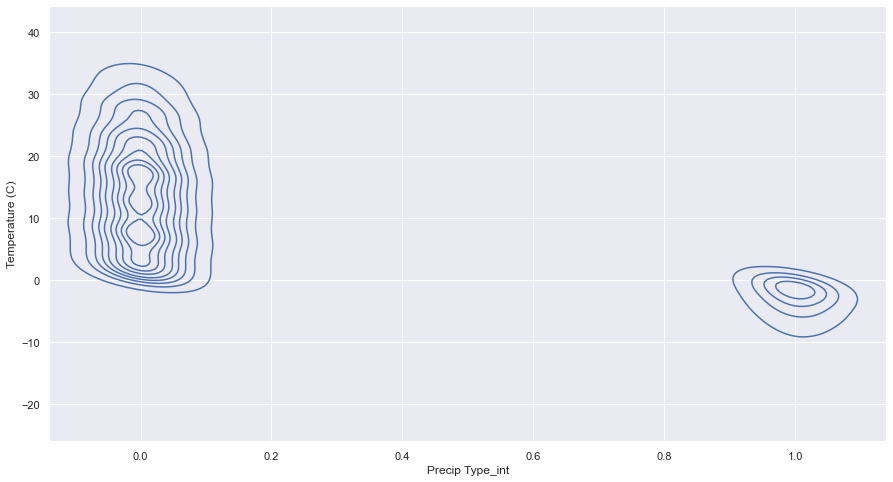

In [426]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x='Precip Type_int', y='Temperature (C)')

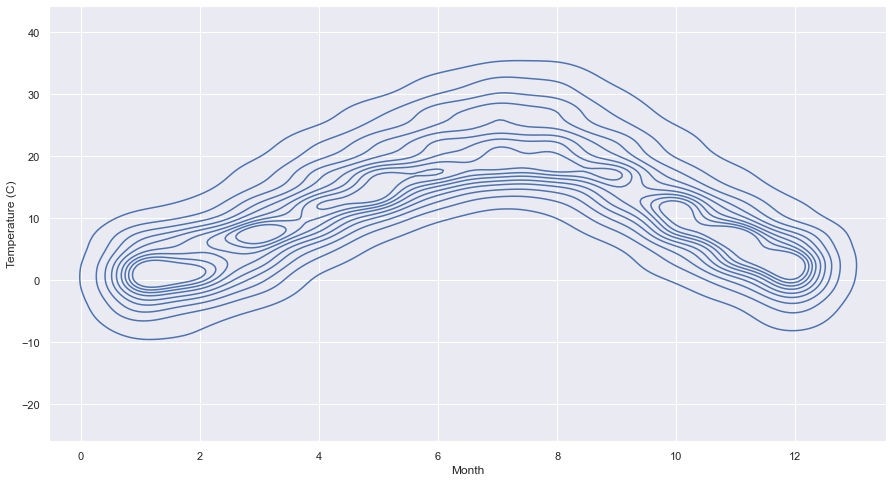

In [425]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x='Month', y='Temperature (C)')

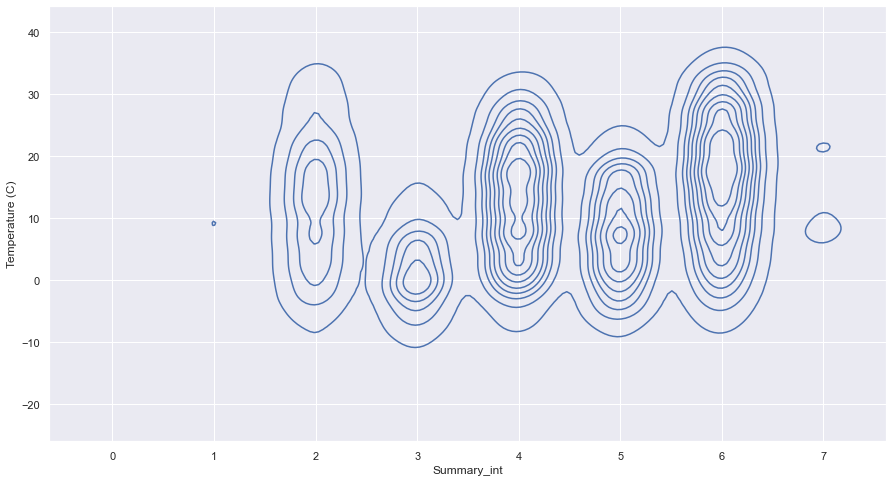

In [424]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x='Summary_int', y='Temperature (C)')

In [ ]:
sns.lmplot('sqft_living','price', df[['price','bedrooms','condition','sqft_living','sqft_lot','sqft_above']], hue='bedrooms', fit_reg=False)

In [63]:
set(df['Precip Type'])

{'rain', 'snow'}

In [408]:
for i in set(df['Precip Type']):
    
    plt.figure(figsize=(8, 6))
    d = df[['Temperature (C)']].loc[df['Precip Type']==i].reset_index(drop=True)
    kernel = scipy.stats.gaussian_kde(d)

    min_amount, max_amount = d.min(), d.max()
    x = np.linspace(min_amount, max_amount, len(d))
    kde_values = kernel(x)

    sns.distplot(d, kde=False, norm_hist=True, label=i)
    plt.plot(x, kde_values)

    plt.ylabel('p')
    plt.xlabel(i)
    # Display values along the abscissa axis only in the interval [0, 10000]

    plt.legend()
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\kde.py:565: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
C:\Users\atmae\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\atmae\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

<Figure size 576x432 with 0 Axes>

### Step 4. You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [ ]:
#Для отчета не надо брать все 

In [462]:
result = pd.DataFrame(columns = ['Value1', 'Values2', 'P-value', 'Corellation','interval from', 'interval to'])

In [463]:

l=np.array(df['Temperature (C)'])
data1 = [df['Temperature (C)'],df['Humidity'],df['Wind Speed (km/h)'],df['Visibility (km)'],df['Pressure (millibars)'],df['Wind Bearing (degrees)'],
         df['Apparent Temperature (C)'],df['Precip Type_int'], df['Summary_int'],df['Year'],df['Month'],df['Week']]
k=0
se = 1/np.sqrt(l.size-3)
alpha = 0.05
z = scipy.stats.norm.ppf(1-alpha/2)
for i in data1:
    k+=1
    for j in data1[k:]:
        r, p = scipy.stats.pearsonr(i,j)
        
        print(i.name,j.name)
        print("p-value:\t", p)
        print("cor:\t\t", r)
        r_z = np.arctanh(r)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo_z, hi_z
        lo, hi = np.tanh((lo_z, hi_z))
        print("interval:\t", lo, hi)
        print()
        d=pd.DataFrame([[i.name,j.name,p,r,lo,hi]], columns = ['Value1', 'Values2', 'P-value', 'Corellation','interval from', 'interval to'])
        result=result.append(d,ignore_index=True)

Temperature (C) Humidity
p-value:	 0.0
cor:		 -0.6322546750278025
interval:	 -0.6360277624035049 -0.6284513570734944

Temperature (C) Wind Speed (km/h)
p-value:	 0.00540625149582242
cor:		 0.008956968343701391
interval:	 0.0026462192222577027 0.015267004056099973

Temperature (C) Visibility (km)
p-value:	 0.0
cor:		 0.3928465717241786
interval:	 0.38749635977776836 0.3981703206275946

Temperature (C) Pressure (millibars)
p-value:	 0.0
cor:		 -0.3081197611445596
interval:	 -0.313820432062976 -0.30239687697933515

Temperature (C) Wind Bearing (degrees)
p-value:	 1.2152154402540676e-20
cor:		 0.02998820447357345
interval:	 0.023681787608566252 0.03629223477966614

Temperature (C) Apparent Temperature (C)
p-value:	 0.0
cor:		 0.9926285641921317
interval:	 0.992535281989797 0.992720684960119

Temperature (C) Precip Type_int
p-value:	 0.0
cor:		 -0.562619727890466
interval:	 -0.5669177081070857 -0.5582911177907541

Temperature (C) Summary_int
p-value:	 0.0
cor:		 0.2134553523669169
interval:

In [464]:
result

,Value1,Values2,P-value,Corellation,interval from,interval to
0,Temperature (C),Humidity,0.000000e+00,-0.632255,-0.636028,-0.628451
1,Temperature (C),Wind Speed (km/h),5.406251e-03,0.008957,0.002646,0.015267
2,Temperature (C),Visibility (km),0.000000e+00,0.392847,0.387496,0.398170
3,Temperature (C),Pressure (millibars),0.000000e+00,-0.308120,-0.313820,-0.302397
4,Temperature (C),Wind Bearing (degrees),1.215215e-20,0.029988,0.023682,0.036292
...,...,...,...,...,...,...
61,Summary_int,Month,5.597900e-15,-0.025152,-0.031458,-0.018845
62,Summary_int,Week,3.454627e-14,-0.024404,-0.030710,-0.018096
63,Year,Month,9.140729e-01,-0.000347,-0.006658,0.005963
64,Year,Week,3.297103e-01,0.003138,-0.003173,0.009449


### Step 5. Choose a task formulation for regression. Estimate multivariate correlation (target -predictors).

<ipython-input-161-2ee8fd7a0377>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool) # make mask


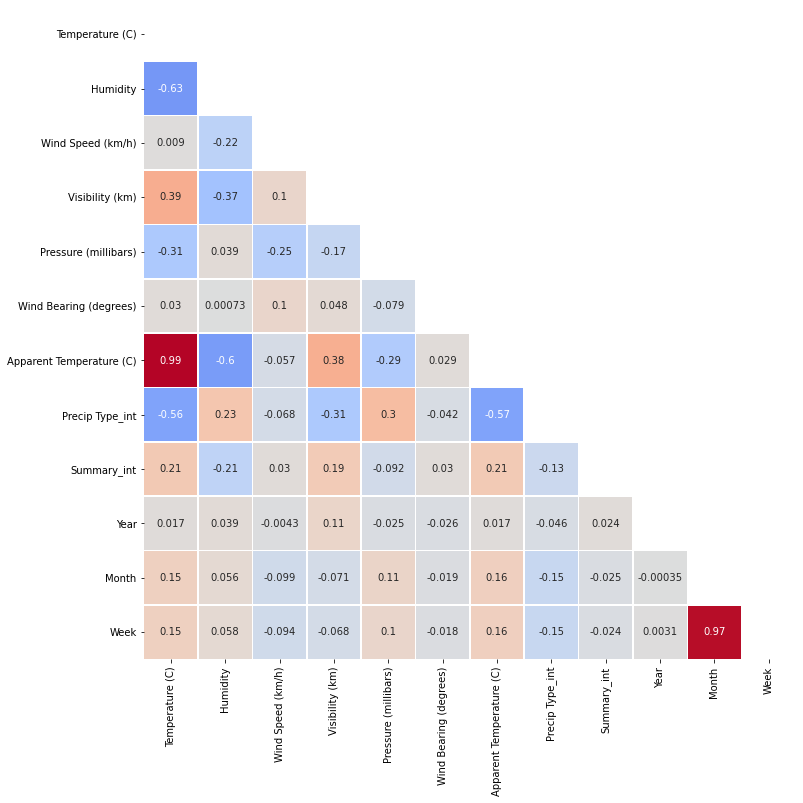

In [161]:
def corrPairs(df):
    '''Pairwise correlation matrix'''
    corr = df.corr() # Compute the correlation matrix
    mask = np.zeros_like(corr, dtype=np.bool) # make mask
    mask[np.triu_indices_from(mask)] = True # mask upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, annot=True, cbar=False)
 # add week to view correlation
plt.figure(figsize=(12,12))
corrPairs(df)

### Step 6. Build regression model and make an analysis of multicollinearity and regularization (if needed).

#### Regression

In [51]:
# Highlight predictors
X = df[['Humidity','Visibility (km)','Pressure (millibars)','Wind Bearing (degrees)','Apparent Temperature (C)','Precip Type_int','Summary_int','Month','Week']]
# Allocate the target variable
y = df[['Temperature (C)']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1000)


In [248]:
y_train

,Temperature (C)
32800,20.000000
81149,0.111111
95420,13.000000
21507,19.933333
13190,28.638889
...,...
58716,21.111111
18782,27.050000
3776,22.450000
71751,9.044444


In [249]:
X.isnull().sum()


Humidity                    0
Wind Speed (km/h)           0
Visibility (km)             0
Pressure (millibars)        0
Wind Bearing (degrees)      0
Apparent Temperature (C)    0
Precip Type_int             0
Summary_int                 0
Year                        0
Month                       0
Week                        0
dtype: int64

In [52]:
x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression(normalize=True)
# Train a linear regression model
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

#### Regression with Lasso

In [53]:
# Lasso regularization
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
print(clf.coef_)

[-0.00000000e+00  2.69668010e-02 -3.02714254e-02 -9.24348086e-05
  8.75598764e-01  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -8.46175162e-04]


In [54]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.coef_
alpha_aic_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([-2.95498318,  0.00644845, -0.04172162,  0.        ,  0.83996922,
       -0.09964286,  0.        ,  0.        ,  0.00341011])

In [55]:
y_pred_lasso = clf.predict(X_test)
y_pred_lasso_aic = model_aic.predict(X_test)

In [56]:
y_pred_lasso=y_pred_lasso.reshape(len(y_pred_lasso),1)
y_pred_lasso_aic=y_pred_lasso_aic.reshape(len(y_pred_lasso),1)

### Step 7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

#### Accuracy

In [57]:
  #we cannot use this metric because  y_true has zero vakues
def mean_absolute_percentage_error(y_test, y_pred): 
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
def wape(y_test, y_pred):
        return (np.sum(np.abs((y_test - y_pred))) /np.sum( y_test)) * 100
   
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def model_accuracy(y_test, y_pred):
    print('model weights:', reg.coef_)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print('Mean absolute error = ', mae)
    print('Mean squared error = ', mse)

    #we cannot use this metric because  y_true has zero vakues
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('Mean absolute percentage error = ', mape)
    wape = (np.sum(np.abs((y_test - y_pred))) /np.sum( y_test)) * 100
    print('Weight absolute percentage error = ', wape)
    
    #RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Root Mean Square Error  = ', rmse)

    print('R^2 =' ,r2_score(y_test,y_pred))

In [58]:
model_accuracy(y_test, y_pred_lasso)

model weights: [[-3.06714459e+00  9.28685861e-03 -4.46314348e-02 -5.06330878e-05
   8.38542887e-01 -1.28128426e-01  1.13133920e-02  3.96859933e-03
   4.33391121e-03]]
Mean absolute error =  0.8677821248563197
Mean squared error =  1.2506950404509158
Mean absolute percentage error =  Temperature (C)    inf
dtype: float64
Weight absolute percentage error =  Temperature (C)    7.271615
dtype: float64
Root Mean Square Error  =  1.1183447770928765
R^2 = 0.986322677165149


In [59]:
model_accuracy(y_test, y_pred_lasso_aic)

model weights: [[-3.06714459e+00  9.28685861e-03 -4.46314348e-02 -5.06330878e-05
   8.38542887e-01 -1.28128426e-01  1.13133920e-02  3.96859933e-03
   4.33391121e-03]]
Mean absolute error =  0.7937540617799684
Mean squared error =  1.0544632459632766
Mean absolute percentage error =  Temperature (C)    inf
dtype: float64
Weight absolute percentage error =  Temperature (C)    6.651293
dtype: float64
Root Mean Square Error  =  1.0268706081894041
R^2 = 0.9884686244319598


In [60]:
model_accuracy(y_test, y_pred)

model weights: [[-3.06714459e+00  9.28685861e-03 -4.46314348e-02 -5.06330878e-05
   8.38542887e-01 -1.28128426e-01  1.13133920e-02  3.96859933e-03
   4.33391121e-03]]
Mean absolute error =  0.7952265861628747
Mean squared error =  1.0536198051509709
Mean absolute percentage error =  Temperature (C)    inf
dtype: float64
Weight absolute percentage error =  Temperature (C)    6.663633
dtype: float64
Root Mean Square Error  =  1.026459840983061
R^2 = 0.9884778481131202


In [61]:
y_pred

array([[16.56888069],
       [21.22382055],
       [ 9.83386195],
       ...,
       [24.44143729],
       [14.48916405],
       [ 4.67418051]])

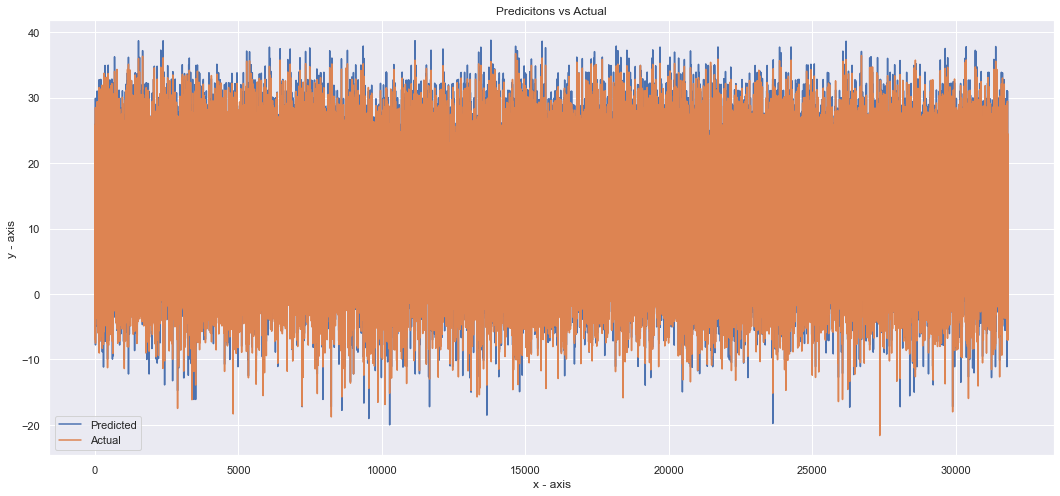

In [79]:
plt.figure(figsize=(18, 8))


plt.plot(y_test.reset_index(drop=True), label = "Predicted")
plt.plot(y_pred, label = "Actual")

plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()

plt.show()

#### Residuals

In [67]:
residuals = y_test -  y_pred
residuals_lasso_aic = y_test -  y_pred_lasso_aic

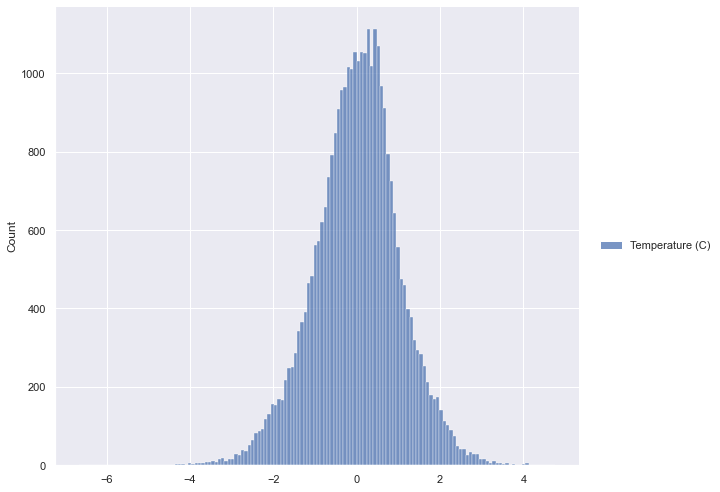

In [68]:

sns.displot(residuals,height=7, aspect=1.2)

In [63]:
residuals_lasso_aic = y_test -  y_pred_lasso_aic

In [80]:
sns.set(rc={"figure.figsize": (15, 15)})
sns.hisplot(residuals_lasso_aic, legend='rasiduals',height=7, aspect=1.2)


AttributeError: module 'seaborn' has no attribute 'hisplot'

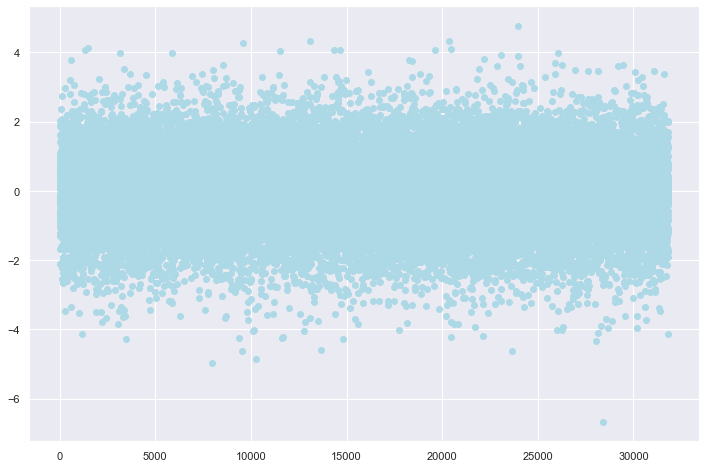

In [69]:
plt.figure(figsize=(12, 8))
plt.plot( residuals.reset_index(drop=True),'o', color='lightblue')

In [398]:
residuals.reset_index(drop=True)

,Temperature (C)
0,-1.668432
1,0.738323
2,-0.704517
3,-0.876833
4,1.875096
...,...
31825,2.076323
31826,-1.144440
31827,-0.569670
31828,-1.702186


Остатки гомогедастичны 

In [402]:
 het_white (residuals)

TypeError: het_white() missing 1 required positional argument: 'exog'